## **Lightcurve and transmission spectra generation using Prometheus**

#### Developed by *Rishabh Garg*

In [1]:
# IMPORTS AND SETUP
from datetime import datetime
from typing import Any, Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import FuncFormatter, MaxNLocator
from scipy.optimize import curve_fit

import Prometheus.pythonScripts.celestialBodies as bodies
import Prometheus.pythonScripts.constants as const
import Prometheus.pythonScripts.gasProperties as gasprop
import Prometheus.pythonScripts.geometryHandler as geom
from exomoon_orbits_tool import TimingModel
import ldtk

Cannot import astroquery.simbad


/home/eclipse/exoplanets/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# PARAMETER AND MODELING FUNCTIONS

def get_exomoon_params(
    planet_name: str,
    element_name: str,
    num_particles: float,
    sigma_v: float,
    moon_radius_io: float,
    starting_orbphase_moon_rad: float,
    moon_q: float,
    light_curve: bool = False,
    observed_planet_phases: Optional[np.ndarray] = None,
    observed_wavelength_transmissions: Optional[np.ndarray] = None
) -> Dict[str, Any]:
    """Sets up parameters for a generic planet with an exomoon scenario."""
    planet_obj = bodies.AvailablePlanets().findPlanet(planet_name)
    hill_radius = planet_obj.a * \
        (planet_obj.M / (3 * planet_obj.hostStar.M))**(1/3)
    if planet_obj is None:
        raise ValueError(f"{planet_name} not found in AvailablePlanets.")

    params: Dict[str, Dict[str, Any]] = {
        "Fundamentals": {
            "ExomoonSource": True, "DopplerPlanetRotation": False, "CLV_variations": True,
            "RM_effect": False, "DopplerOrbitalMotion": True,
        },
        "Architecture": {
            "planetName": planet_name, "R_moon": moon_radius_io * const.R_Io,
            # 41% of Hill Sphere Radius referencing Kisare & Fabrycky 2024
            "a_moon": 0.41 * hill_radius, "starting_orbphase_moon": starting_orbphase_moon_rad,
        },
        "Scenarios": {"exomoon": {"q_moon": moon_q}},
        "Species": {"exomoon": {element_name: {"Nparticles": num_particles, "sigma_v": sigma_v}}},
        "Grids": {
            "x_midpoint": planet_obj.a, "x_border": 5.0 * hill_radius, "x_steps": 30,
            "phi_steps": 60, "rho_steps": 40, "upper_rho": planet_obj.hostStar.R,
            "orbphase_border": 0, "orbphase_steps": 1,
        },
    }

    if light_curve:
        if observed_planet_phases is not None and len(observed_planet_phases) > 0:
            min_obs_planet_phase_frac = np.min(observed_planet_phases)
            max_obs_planet_phase_frac = np.max(observed_planet_phases)
            planet_phase_border_fractional = max(
                abs(min_obs_planet_phase_frac), abs(max_obs_planet_phase_frac))
            params["Grids"]["orbphase_border"] = (
                planet_phase_border_fractional + 0.005) * 2.0 * np.pi
        else:
            params["Grids"]["orbphase_border"] = 0.065 * 2.0 * np.pi
        params["Grids"]["orbphase_steps"] = 201

    element_filters = {
        "NaI": ("NaD_filter", 588.8, 590.0, {
            "lower_w": 5.888e-05, "upper_w": 5.900e-05, "resolutionLow": 5e-09,
            "widthHighRes": 0.75e-8, "resolutionHigh": 2e-10,
        }),
        "KI": ("KD_filter", 766.0, 770.5, {
            "lower_w": 7.660e-05, "upper_w": 7.705e-05, "resolutionLow": 5e-09,
            "widthHighRes": 1.0e-08, "resolutionHigh": 2e-10,
        }),
    }

    if element_name in element_filters:
        filter_name, fmin, fmax, grid_updates = element_filters[element_name]
        params["Grids"].update(grid_updates)
        filters = [ldtk.BoxcarFilter(filter_name, fmin, fmax)]
        sc = ldtk.LDPSetCreator(
            teff=(planet_obj.hostStar.T_eff, planet_obj.hostStar.dT_eff),
            logg=(planet_obj.hostStar.log_g, planet_obj.hostStar.dlog_g),
            z=(planet_obj.hostStar.Z, planet_obj.hostStar.dZ), filters=filters
        )
        ps = sc.create_profiles()
        u1, u2 = ps.coeffs_qd(do_mc=False)
        params["Architecture"]["CLV_u1"], params["Architecture"]["CLV_u2"] = u1[0][0], u2[0][0]
    else:
        print(
            f"Warning: Element {element_name} specific grid not fully set. Using generic wide grid.")
        params["Grids"].update({"lower_w": 0.5e-4, "upper_w": 1.0e-4, "resolutionLow": 1e-8,
                                "widthHighRes": 1e-8, "resolutionHigh": 1e-9})
        filters = [ldtk.BoxcarFilter("Generic_filter", 5000, 10000)]
        params["Architecture"]["CLV_u1"], params["Architecture"]["CLV_u2"] = 0.3, 0.1

    if not light_curve and observed_wavelength_transmissions is not None:
        print("Transmission spectrum mode: Overwriting wavelength grid from observed data.")
        obs_w_cm = observed_wavelength_transmissions * 1e-8
        min_w, max_w = np.min(obs_w_cm), np.max(obs_w_cm)
        padding = (max_w - min_w) * 0.01
        params["Grids"].update(
            {"lower_w": min_w - padding, "upper_w": max_w + padding})

    return params


def get_hydrostatic_params(
    planet_name: str, element_name: str, mixing_ratio: float, temperature: float,
    reference_pressure_bar: float, mean_molecular_weight_amu: float, light_curve: bool = False
) -> Dict[str, Any]:
    """Sets up parameters for a planet with a hydrostatic atmosphere scenario."""
    # This function reuses the logic from get_exomoon_params for grid and CLV setup
    # by calling it and then modifying the relevant parts.
    base_params = get_exomoon_params(
        planet_name, element_name, 0, 0, 0, 0, 0, light_curve=light_curve
    )

    planet_obj = bodies.AvailablePlanets().findPlanet(planet_name)
    pressure_cgs = reference_pressure_bar * 1e6
    mu_cgs = mean_molecular_weight_amu * const.amu

    base_params["Fundamentals"]["ExomoonSource"] = False
    base_params["Scenarios"] = {
        "hydrostatic": {"T": temperature, "P_0": pressure_cgs, "mu": mu_cgs}
    }
    base_params["Species"] = {
        "hydrostatic": {element_name: {"chi": mixing_ratio}}
    }
    # Adjust grid for hydrostatic case
    base_params["Grids"]["x_border"] = 5.0 * planet_obj.R
    base_params["Grids"]["x_steps"] = 200

    return base_params


def load_observed(filepath: str) -> Tuple[Optional[np.ndarray], Optional[np.ndarray], Optional[np.ndarray]]:
    """Loads observed data from a 2 or 3 column text file."""
    try:
        data = np.loadtxt(filepath)
        if data.ndim == 1:
            data = data.reshape(1, -1)  # Ensure 2D for consistent indexing

        if data.shape[1] == 3:
            return data[:, 0], data[:, 1], data[:, 2]
        elif data.shape[1] == 2:
            print(
                f"Warning: Data file {filepath} has 2 columns. Assuming zero error.")
            return data[:, 0], data[:, 1], np.zeros_like(data[:, 0])
        else:
            raise ValueError(f"Data file {filepath} must have 2 or 3 columns.")
    except Exception as e:
        print(f"Error loading observed data from {filepath}: {e}")
        return None, None, None


def run_prometheus_simulation(params: Dict[str, Any]) -> Tuple[Any, np.ndarray, list]:
    """Encapsulates the setup and execution of a Prometheus simulation."""
    fundamentals = params["Fundamentals"]
    architecture = params["Architecture"]
    species = params["Species"]
    grids = params["Grids"]
    scenarios = params["Scenarios"]

    planet = bodies.AvailablePlanets().findPlanet(architecture["planetName"])
    if fundamentals["CLV_variations"]:
        planet.hostStar.addCLVparameters(architecture.get(
            "CLV_u1", 0.0), architecture.get("CLV_u2", 0.0))

    wavelengthGrid = gasprop.WavelengthGrid(
        grids["lower_w"], grids["upper_w"], grids["widthHighRes"],
        grids["resolutionLow"], grids["resolutionHigh"]
    )
    spatialGrid = geom.Grid(
        grids["x_midpoint"], grids["x_border"], int(grids["x_steps"]),
        grids["upper_rho"], int(grids["rho_steps"]), int(grids["phi_steps"]),
        grids["orbphase_border"], int(grids["orbphase_steps"])
    )

    scenarioList = []
    if "exomoon" in scenarios:
        moon = bodies.Moon(architecture["starting_orbphase_moon"],
                           architecture["R_moon"], architecture["a_moon"], planet)
        species_name = list(species["exomoon"].keys())[0]
        num_p = species["exomoon"][species_name]["Nparticles"]
        scenario = gasprop.MoonExosphere(
            num_p, scenarios["exomoon"]["q_moon"], moon)
        scenario.addConstituent(
            species_name, species["exomoon"][species_name]["sigma_v"])
        scenarioList.append(scenario)
    elif "hydrostatic" in scenarios:
        scenario = gasprop.HydrostaticAtmosphere(
            scenarios["hydrostatic"]["T"], scenarios["hydrostatic"]["P_0"], scenarios["hydrostatic"]["mu"], planet
        )
        species_name = list(species["hydrostatic"].keys())[0]
        scenario.addConstituent(
            species_name, species["hydrostatic"][species_name]["chi"])
        scenarioList.append(scenario)

    scenarioList[-1].constituents[-1].addLookupFunctionToConstituent(
        wavelengthGrid)

    atmos = gasprop.Atmosphere(
        scenarioList, fundamentals["DopplerOrbitalMotion"])
    transit_model = gasprop.Transit(atmos, wavelengthGrid, spatialGrid)
    transit_model.addWavelength()

    print(
        f"Running PROMETHEUS for {'Exomoon' if 'exomoon' in scenarios else 'Hydrostatic'} model...")
    start_time = datetime.now()
    R_values = transit_model.sumOverChords()
    end_time = datetime.now()
    print(f"Simulation finished. Elapsed time: {end_time - start_time}")

    return transit_model, R_values, scenarioList


def calculate_light_curve_from_spectra(
    transit_model: Any, R_values: np.ndarray, spatialGrid: Any, filter_bw_cm: float, v_los_planet: Optional[np.ndarray] = None
) -> Tuple[np.ndarray, np.ndarray]:
    """Calculates a light curve from a simulated spectral data cube."""
    orbital_phases_rad = spatialGrid.constructOrbphaseAxis()
    orbital_phases_plot = orbital_phases_rad / (2.0 * np.pi)

    if v_los_planet is None:
        v_los_planet = np.zeros_like(orbital_phases_rad)

    shifts = const.calculateDopplerShift(v_los_planet)
    # Vacuum wavelengths for Na D lines
    NaD1_cm, NaD2_cm = 5.897558147e-5, 5.891583253e-5

    light_curve_sim = []
    for i, R_spectrum in enumerate(R_values):
        shift_factor = shifts[i]
        shifted_D1 = NaD1_cm / shift_factor
        shifted_D2 = NaD2_cm / shift_factor

        # Define filter bands around the Doppler-shifted lines
        sel1 = (transit_model.wavelength >= shifted_D1 - filter_bw_cm / 2) & \
               (transit_model.wavelength <= shifted_D1 + filter_bw_cm / 2)
        sel2 = (transit_model.wavelength >= shifted_D2 - filter_bw_cm / 2) & \
               (transit_model.wavelength <= shifted_D2 + filter_bw_cm / 2)

        combined_selection = sel1 | sel2
        if np.any(combined_selection):
            light_curve_sim.append(np.mean(R_spectrum[combined_selection]))
        else:
            light_curve_sim.append(1.0)

    return orbital_phases_plot, np.array(light_curve_sim)

In [3]:
# PLOTTING FUNCTIONS
# =============================================================================

def plot_light_curve(
    orbital_phases_sim: np.ndarray, light_curve_values_sim: np.ndarray,
    orbital_phases_obs: Optional[np.ndarray], light_curve_values_obs: Optional[np.ndarray], light_curve_errors_obs: Optional[np.ndarray],
    element_name: str, planet_name: str, num_particles_str: str, sigma_v_str: str, filter_bandwidth_angstrom: float,
    orbital_phases_hydro: Optional[np.ndarray] = None, light_curve_values_hydro: Optional[np.ndarray] = None,
    title_suffix: str = ""
) -> None:
    """Plots observed data, a primary simulation (exomoon), and an optional secondary simulation (hydrostatic)."""
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))

    # Plot observed data
    if orbital_phases_obs is not None and light_curve_values_obs is not None:
        ax.errorbar(orbital_phases_obs, light_curve_values_obs + 1, yerr=light_curve_errors_obs, fmt='o', color='royalblue',
                    label='Observed Data', capsize=4, elinewidth=1.5, markeredgewidth=1.5, markersize=8, ecolor='lightgray', zorder=5)

    # Plot exomoon simulation
    ax.plot(orbital_phases_sim, light_curve_values_sim, color="crimson",
            label=f"Simulated Exomoon ({element_name})", zorder=10, linewidth=2.5)

    # Plot hydrostatic simulation
    if orbital_phases_hydro is not None and light_curve_values_hydro is not None:
        ax.plot(orbital_phases_hydro, light_curve_values_hydro, color="darkgreen", linestyle='--',
                label="Simulated Hydrostatic Planet", zorder=8, linewidth=2)

    title_text = f"{planet_name} {element_name} Light Curve{title_suffix}\nFilter: {filter_bandwidth_angstrom:.2f} Å, Particles: {num_particles_str}, σ_v: {sigma_v_str} cm/s"
    ax.set_title(title_text, fontweight='bold', fontsize=16)
    ax.set_xlabel("Orbital Phase (𝜙)", fontsize=14)
    ax.set_ylabel("Relative Flux (F / F_star)", fontsize=14)

    # Smart axis limits
    all_x = list(orbital_phases_sim)
    all_y = list(light_curve_values_sim)
    if orbital_phases_obs is not None:
        all_x.extend(orbital_phases_obs)
    if light_curve_values_obs is not None:
        all_y.extend(light_curve_values_obs + 1)
    if orbital_phases_hydro is not None:
        all_x.extend(orbital_phases_hydro)
    if light_curve_values_hydro is not None:
        all_y.extend(light_curve_values_hydro)

    if all_x:
        ax.set_xlim(np.min(all_x) - 0.005, np.max(all_x) + 0.005)
    if all_y:
        min_y, max_y = np.min(all_y), np.max(all_y)
        padding = (max_y - min_y) * 0.1
        ax.set_ylim(min_y - padding, max_y + padding)

    ax.legend(fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)
    fig.tight_layout(pad=1.5)
    plt.show()


def plot_transmission_spectrum(
    wavelength_sim: np.ndarray, spectrum_sim: np.ndarray,
    element_name: str, planet_name: str, num_particles_str: str, sigma_v_str: str,
    # Parameters for BINNED observed data
    obs_wavelength_binned: Optional[np.ndarray], obs_transmission_binned: Optional[np.ndarray], obs_errors_binned: Optional[np.ndarray],
    # Parameters for FULL-RESOLUTION observed data
    obs_wavelength_full: Optional[np.ndarray] = None, obs_transmission_full: Optional[np.ndarray] = None, obs_errors_full: Optional[np.ndarray] = None,
    # Comparative model
    wavelength_hydro: Optional[np.ndarray] = None, spectrum_hydro: Optional[np.ndarray] = None,
    title_suffix: str = ""
) -> None:
    """Plots observed (binned and full-res with errors), exomoon, and optional hydrostatic transmission spectra."""
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))

    # --- Plot Data and Models ---
    # Convert observed transit depth in % to relative flux (1.0 - depth/100)

    # Plot FULL-RESOLUTION observed data with errors (faint, low zorder)
    if obs_wavelength_full is not None and obs_transmission_full is not None:
        obs_flux_full = 1.0 + (obs_transmission_full / 100.0)
        obs_flux_err_full = obs_errors_full / \
            100.0 if obs_errors_full is not None else np.zeros_like(
                obs_flux_full)
        ax.errorbar(obs_wavelength_full, obs_flux_full, yerr=obs_flux_err_full,
                    fmt='.', color='gray', ecolor='lightgray', alpha=0.3, elinewidth=0.5, capsize=0, zorder=1,
                    label='Observed Data (Full Res)')

    # Plot BINNED observed data with errors (prominent, high zorder)
    if obs_wavelength_binned is not None and obs_transmission_binned is not None:
        obs_flux_binned = 1.0 + (obs_transmission_binned / 100.0)
        obs_flux_err_binned = obs_errors_binned / \
            100.0 if obs_errors_binned is not None else np.zeros_like(
                obs_flux_binned)
        ax.errorbar(obs_wavelength_binned, obs_flux_binned, yerr=obs_flux_err_binned, fmt='o', color='royalblue',
                    label='Observed Data (Binned)', capsize=3, ecolor='dimgray', zorder=5, alpha=0.9, markeredgecolor='white')

    # Plot exomoon simulation (highest zorder)
    ax.plot(wavelength_sim * 1e8, spectrum_sim, color="crimson",
            label="Simulated Exomoon Spectrum", zorder=10, linewidth=2)

    # Plot hydrostatic simulation
    if wavelength_hydro is not None and spectrum_hydro is not None:
        ax.plot(wavelength_hydro * 1e8, spectrum_hydro, color="darkgreen", linestyle='--',
                label="Simulated Hydrostatic Planet", zorder=8, linewidth=1.5)

    # --- Formatting and Labels ---
    title_text = f"{planet_name} {element_name} Transmission Spectrum{title_suffix}\nParticles: {num_particles_str}, σ_v: {sigma_v_str} cm/s"
    ax.set_title(title_text, fontsize=16, fontweight='bold')
    ax.set_xlabel("Wavelength (Å)", fontsize=14)
    ax.set_ylabel("Relative Flux (F / F_star)", fontsize=14)

    # --- Smart Axis Limits with Fixed Maximum ---
    all_y = list(spectrum_sim)
    if spectrum_hydro is not None:
        all_y.extend(spectrum_hydro)
    if 'obs_flux_binned' in locals():
        all_y.extend(obs_flux_binned)

    if all_y:
        min_y = np.min(all_y)
        max_y = np.max(all_y)
        padding = (1.0 - min_y) * 0.15 if (1.0 - min_y) > 1e-6 else 0.005
        ax.set_ylim(min_y - padding, max_y + padding)  # Enforce fixed y-axis max

    # Re-order legend handles to be more logical
    handles, labels = ax.get_legend_handles_labels()
    try:
        # Create a desired order, labels that aren't found will be ignored
        desired_order = ['Observed Data (Binned)', 'Observed Data (Full Res)',
                         'Simulated Exomoon Spectrum', 'Simulated Hydrostatic Planet']
        # Create new lists based on the desired order
        new_handles = [handles[labels.index(lbl)]
                       for lbl in desired_order if lbl in labels]
        new_labels = [lbl for lbl in desired_order if lbl in labels]
        ax.legend(new_handles, new_labels, fontsize=12)
    except (ValueError, IndexError):  # Fallback if something goes wrong
        ax.legend(fontsize=12)

    ax.grid(True, linestyle="--", alpha=0.6)
    ax.tick_params(axis='both', which='major', labelsize=12)
    fig.tight_layout()
    plt.show()

### Main Script

In [4]:
# --- Section 1: Initial User Inputs ---
PLANET_NAME = input("Enter the planet name (e.g., WASP-49b): ").strip()
ELEMENT_NAME = input("Enter the species (e.g. NaI, KI): ").strip()
NUM_PARTICLES = float(
    input(f"Enter number of {ELEMENT_NAME} particles (e.g., 1e32): "))
SIGMA_V = float(input(f"Enter {ELEMENT_NAME} sigma_v in cm/s (e.g., 2e5): "))
MOON_RADIUS_IO = 1.0
MOON_EXOSPHERE_Q = 3.34
FILTER_BANDWIDTH_ANGSTROM = 0.75
FILTER_BANDWIDTH_CM = FILTER_BANDWIDTH_ANGSTROM * 1e-8
PLANET_ORBITAL_PERIOD_DAYS = bodies.AvailablePlanets(
).findPlanet(PLANET_NAME).orbitalPeriod

In [5]:
# --- Section 2: Multi-Night Data Processing and Fitting ---
BASE_FILE_PATH = input("Enter base path for light curve data (use {} for night number, e.g., 'data/night_{}.txt'): ").strip()
NUM_NIGHTS = int(input("Enter the total number of nights of observation: ").strip())

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / stddev)**2 / 2.0)

def convert_phase_to_minutes(phase, orbital_period_days):
    return phase * orbital_period_days * 24 * 60

observation_dates = []
approximate_phases_rad = []
all_obs_data = {} # Dictionary to store data per night: {1: (phases, flux, errors), 2: ...}

print("\n--- Processing Each Night of Observation ---")
for i in range(1, NUM_NIGHTS + 1):
    print(f"\n--- Night {i} ---")
    filepath = BASE_FILE_PATH.format(i)
    obs_phases, obs_flux, obs_errors = load_observed(filepath)
    if obs_phases is None:
        print(f"Could not load data for Night {i}. Skipping.")
        continue

    date_str = input(f"Enter mid-observation date for Night {i} (YYYY-MM-DD HH:MM:SS): ").strip()
    try:
        datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        print("Invalid date format. Skipping this night.")
        continue
    
    all_obs_data[i] = (obs_phases, obs_flux, obs_errors)
    observation_dates.append(date_str)

    time_from_mid_transit_min = convert_phase_to_minutes(obs_phases, PLANET_ORBITAL_PERIOD_DAYS)
    obs_flux_inv = 1.0 - obs_flux # Fit absorption depth
    initial_guesses = [np.max(obs_flux_inv), time_from_mid_transit_min[np.argmax(obs_flux_inv)], 15.0]
    
    phase_guess_rad = 0.0 # Default phase
    try:
        popt, _ = curve_fit(gaussian, time_from_mid_transit_min, obs_flux_inv, p0=initial_guesses, sigma=obs_errors, maxfev=5000)
        T_peak_minutes, fit_stddev = popt[1], popt[2]
        fwhm_minutes = 2.355 * abs(fit_stddev)
        print(f"Fit successful: Peak absorption at {T_peak_minutes:.2f} min.")
        if abs(T_peak_minutes) < fwhm_minutes / 2.0: phase_guess_rad = np.pi # Transiting planet
        elif T_peak_minutes < 0: phase_guess_rad = 1.5 * np.pi # Trailing
        else: phase_guess_rad = 0.5 * np.pi # Leading
    except RuntimeError:
        print(f"Curve fitting failed for Night {i}. Using default phase.")

    print(f"Initial phase guess for Night {i}: {phase_guess_rad:.2f} radians")
    approximate_phases_rad.append(phase_guess_rad)


--- Processing Each Night of Observation ---

--- Night 1 ---
Fit successful: Peak absorption at 13.87 min.
Initial phase guess for Night 1: 3.14 radians

--- Night 2 ---
Fit successful: Peak absorption at 88703.79 min.
Initial phase guess for Night 2: 3.14 radians

--- Night 3 ---
Fit successful: Peak absorption at 205.54 min.
Initial phase guess for Night 3: 3.14 radians


In [6]:
# --- Section 3: Run Orbit Solver and Select a Solution ---
selected_solution = None
if len(observation_dates) >= 2:
    fix_phase_fraction = approximate_phases_rad[0] / (2 * np.pi)
    approx_phases_fraction = [p / (2 * np.pi) for p in approximate_phases_rad[1:]]

    tm = TimingModel(observation_dates[0], fix_phase_fraction)
    tm.set_approximate_phases(observation_dates[1:], approx_phases_fraction)
    
    print("\n--- Running exomoon_orbits_tool to find consistent orbital solutions... ---")
    tm.search_orbitsolution(error_threshold=0.1)
    print("Search complete. Results saved to 'timings.csv'.")

    try:
        solutions_df = pd.read_csv('timings.csv')
        if not solutions_df.empty:
            print("\n--- Found Potential Orbital Solutions ---")
            print(solutions_df)
            solution_idx = int(input("Enter the index (row number) of the solution you want to use: ").strip())
            selected_solution = solutions_df.iloc[solution_idx]
        else:
            print("No solutions found in 'timings.csv'.")
    except (FileNotFoundError, IndexError, ValueError) as e:
        print(f"Could not select a solution due to an error: {e}")
else:
    print("\nWarning: Fewer than 2 nights of data. Skipping orbit solver.")


--- Running exomoon_orbits_tool to find consistent orbital solutions... ---
Search complete. Results saved to 'timings.csv'.

--- Found Potential Orbital Solutions ---
      a [R_P]    T [hr]  Phase of date 2015-12-06 00:00:00  \
0    1.102200  5.774267                                0.5   
1    1.102225  5.774463                                0.5   
2    1.102250  5.774660                                0.5   
3    1.116026  5.883253                                0.5   
4    1.116051  5.883451                                0.5   
..        ...       ...                                ...   
749  1.573699  9.851187                                0.5   
750  1.573724  9.851422                                0.5   
751  1.573749  9.851656                                0.5   
752  1.573774  9.851891                                0.5   
753  1.573799  9.852126                                0.5   

     Phase of date 2015-12-31 00:00:00  Phase of date 2016-01-14 00:00:00  
0         


--- Preparing Simulations Based on Selected Orbital Solution ---

--- Generating Comparative Hydrostatic Model ---
Running PROMETHEUS for Hydrostatic model...
Simulation finished. Elapsed time: 0:05:55.775582

--- Simulating Exomoon for Night 1 (2015-12-06 00:00:00) ---
Using refined phase: 3.1416 radians
Running PROMETHEUS for Exomoon model...
Simulation finished. Elapsed time: 0:01:42.027464


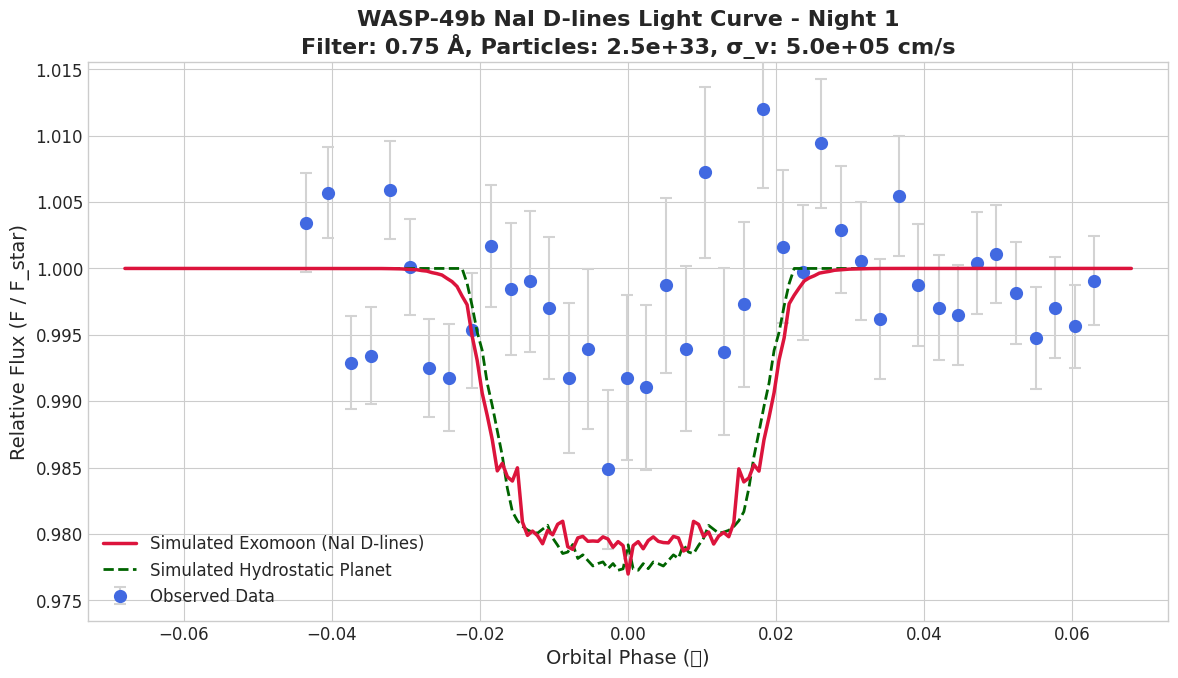


--- Simulating Exomoon for Night 2 (2015-12-31 00:00:00) ---
Using refined phase: 2.7332 radians
Running PROMETHEUS for Exomoon model...
Simulation finished. Elapsed time: 0:01:40.936025


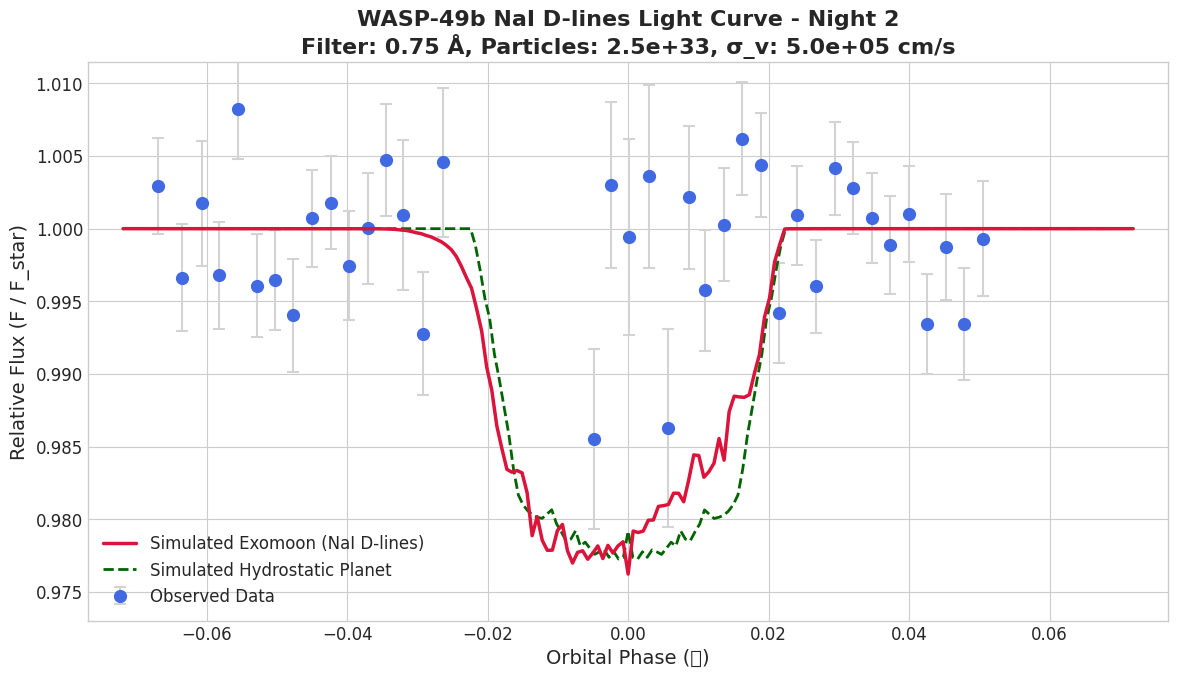


--- Simulating Exomoon for Night 3 (2016-01-14 00:00:00) ---
Using refined phase: 3.7548 radians
Running PROMETHEUS for Exomoon model...
Simulation finished. Elapsed time: 0:01:41.591988


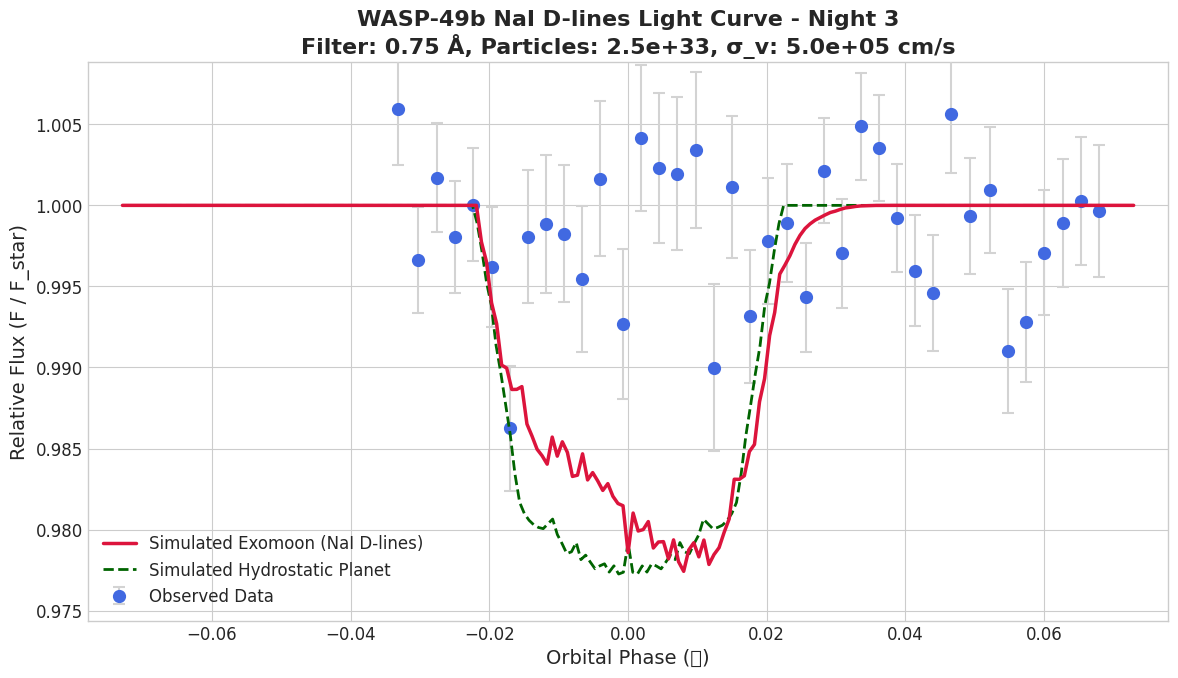

In [7]:
# --- Section 4: Run Simulations and Plot Results ---
if selected_solution is not None:
    print("\n--- Preparing Simulations Based on Selected Orbital Solution ---")

    # Run the hydrostatic simulation ONCE, as it's constant for all nights
    print("\n--- Generating Comparative Hydrostatic Model ---")
    hydrostatic_params = get_hydrostatic_params(
        planet_name=PLANET_NAME, element_name=ELEMENT_NAME, mixing_ratio=1.7e-6,
        temperature=1500, reference_pressure_bar=1.0, mean_molecular_weight_amu=2.3, light_curve=True
    )
    # Use the grid from the first night's observation for the hydrostatic model
    hydrostatic_params['Grids']['orbphase_border'] = (
        np.max(np.abs(all_obs_data[1][0])) + 0.005) * 2.0 * np.pi

    hydro_model, hydro_R_values, _ = run_prometheus_simulation(
        hydrostatic_params)
    phases_hydro, lc_hydro = calculate_light_curve_from_spectra(
        hydro_model, hydro_R_values, hydro_model.spatialGrid, FILTER_BANDWIDTH_CM
    )

    # Now, loop and run exomoon simulation for each night
    for i, date_str in enumerate(observation_dates):
        night_num = i + 1
        print(
            f"\n--- Simulating Exomoon for Night {night_num} ({date_str}) ---")

        # Get refined phase for this night from the selected solution
        phase_col_name = f'Phase of date {date_str}'
        refined_phase_fraction = selected_solution[phase_col_name]
        final_phase_rad = refined_phase_fraction * (2 * np.pi)
        print(f"Using refined phase: {final_phase_rad:.4f} radians")

        # Get the observed data for this specific night
        obs_phases_sim, obs_flux_sim, obs_errors_sim = all_obs_data[night_num]

        # Get params and run simulation for the exomoon
        exomoon_params = get_exomoon_params(
            PLANET_NAME, ELEMENT_NAME, NUM_PARTICLES, SIGMA_V, MOON_RADIUS_IO,
            final_phase_rad, MOON_EXOSPHERE_Q, light_curve=True,
            observed_planet_phases=obs_phases_sim
        )
        exomoon_model, exomoon_R_values, exomoon_scenarios = run_prometheus_simulation(
            exomoon_params)

        # Calculate exomoon light curve
        # Check if the scenario is indeed an exomoon before trying to access the moon object
        if exomoon_scenarios and hasattr(exomoon_scenarios[0], 'moon'):
            v_los = np.array([exomoon_scenarios[0].moon.getLOSvelocity(
                ph) for ph in exomoon_model.spatialGrid.constructOrbphaseAxis()])
        else:
            # Fallback for non-moon scenarios, though this loop should only have exomoons
            v_los = np.zeros_like(
                exomoon_model.spatialGrid.constructOrbphaseAxis())

        phases_exomoon, lc_exomoon = calculate_light_curve_from_spectra(
            exomoon_model, exomoon_R_values, exomoon_model.spatialGrid, FILTER_BANDWIDTH_CM, v_los_planet=v_los
        )

        # Plot everything for this night
        plot_light_curve(
            phases_exomoon, lc_exomoon,
            obs_phases_sim, obs_flux_sim, obs_errors_sim,
            f"{ELEMENT_NAME} D-lines", PLANET_NAME, f"{NUM_PARTICLES:.1e}", f"{SIGMA_V:.1e}",
            FILTER_BANDWIDTH_ANGSTROM,
            orbital_phases_hydro=phases_hydro, light_curve_values_hydro=lc_hydro,
            title_suffix=f" - Night {night_num}"
        )
else:
    print("\nSkipping simulations as no valid orbital solution was selected.")


--- Preparing Transmission Spectra Simulations ---

Enter file paths for observed spectra. Use {} for the night number.

--- Generating Comparative Hydrostatic Spectrum ---
Running PROMETHEUS for Hydrostatic model...
Simulation finished. Elapsed time: 0:00:01.567215

--- Simulating and Plotting Spectrum for Night 1 (2015-12-06 00:00:00) ---
Using refined phase: 3.1416 radians
Transmission spectrum mode: Overwriting wavelength grid from observed data.
Running PROMETHEUS for Exomoon model...
Simulation finished. Elapsed time: 0:00:00.570381


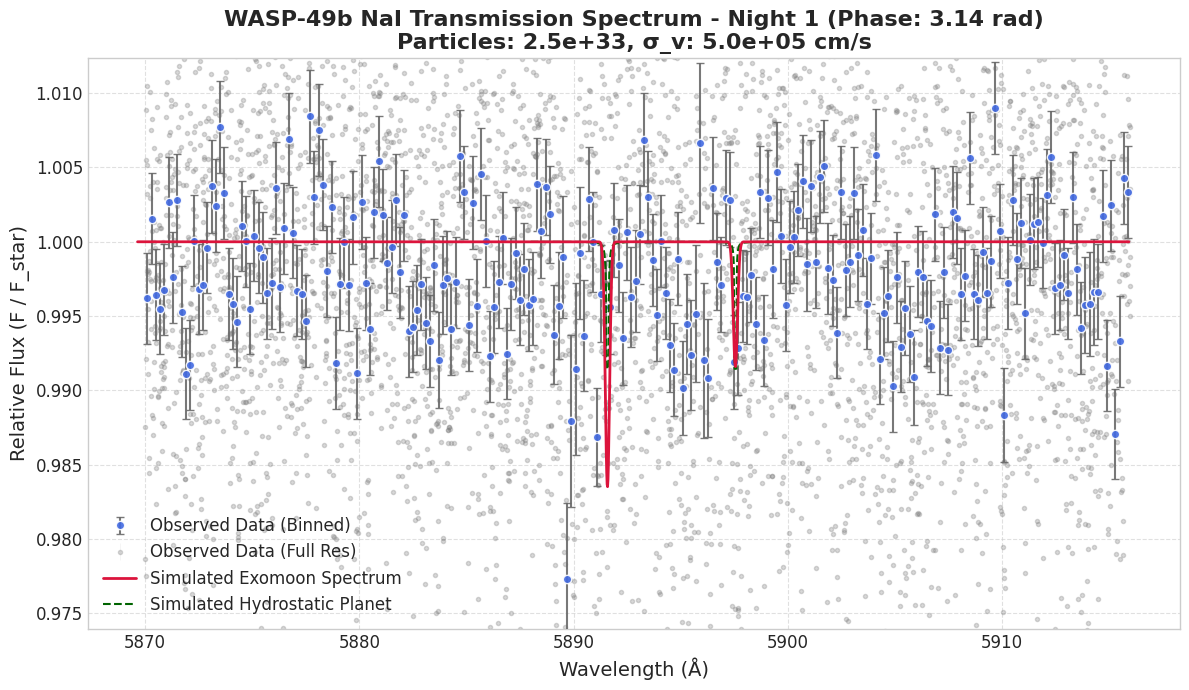


--- Simulating and Plotting Spectrum for Night 2 (2015-12-31 00:00:00) ---
Using refined phase: 2.7332 radians
Transmission spectrum mode: Overwriting wavelength grid from observed data.
Running PROMETHEUS for Exomoon model...
Simulation finished. Elapsed time: 0:00:00.549838


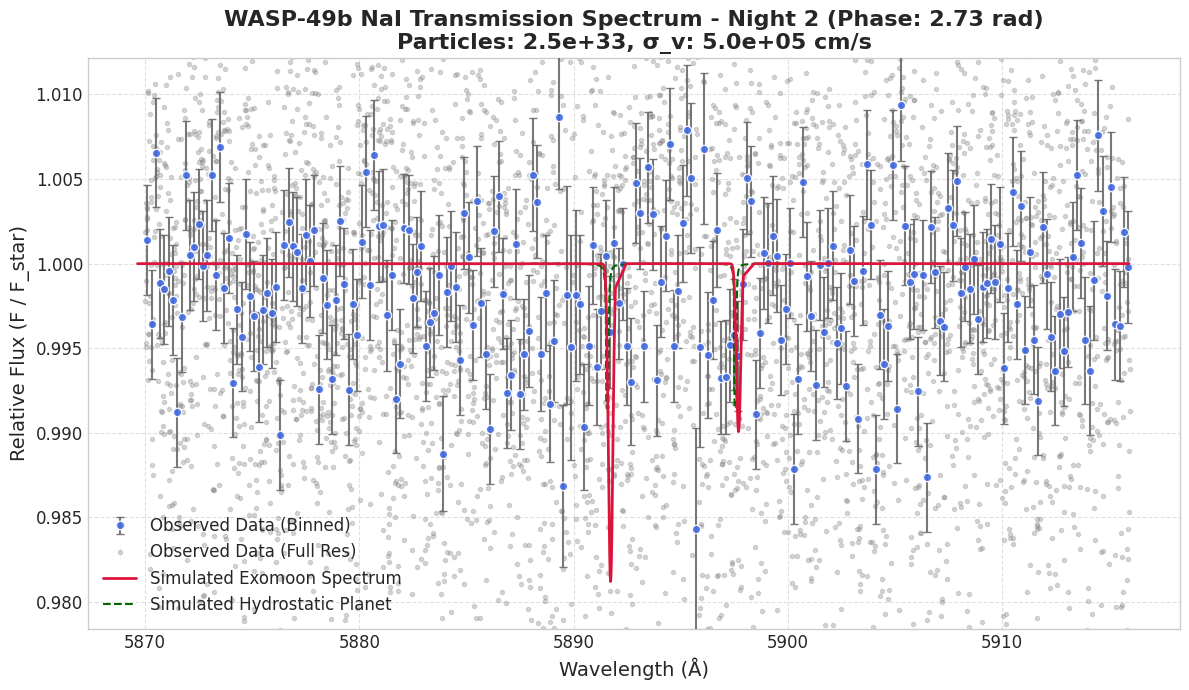


--- Simulating and Plotting Spectrum for Night 3 (2016-01-14 00:00:00) ---
Using refined phase: 3.7548 radians
Transmission spectrum mode: Overwriting wavelength grid from observed data.
Running PROMETHEUS for Exomoon model...
Simulation finished. Elapsed time: 0:00:00.562579


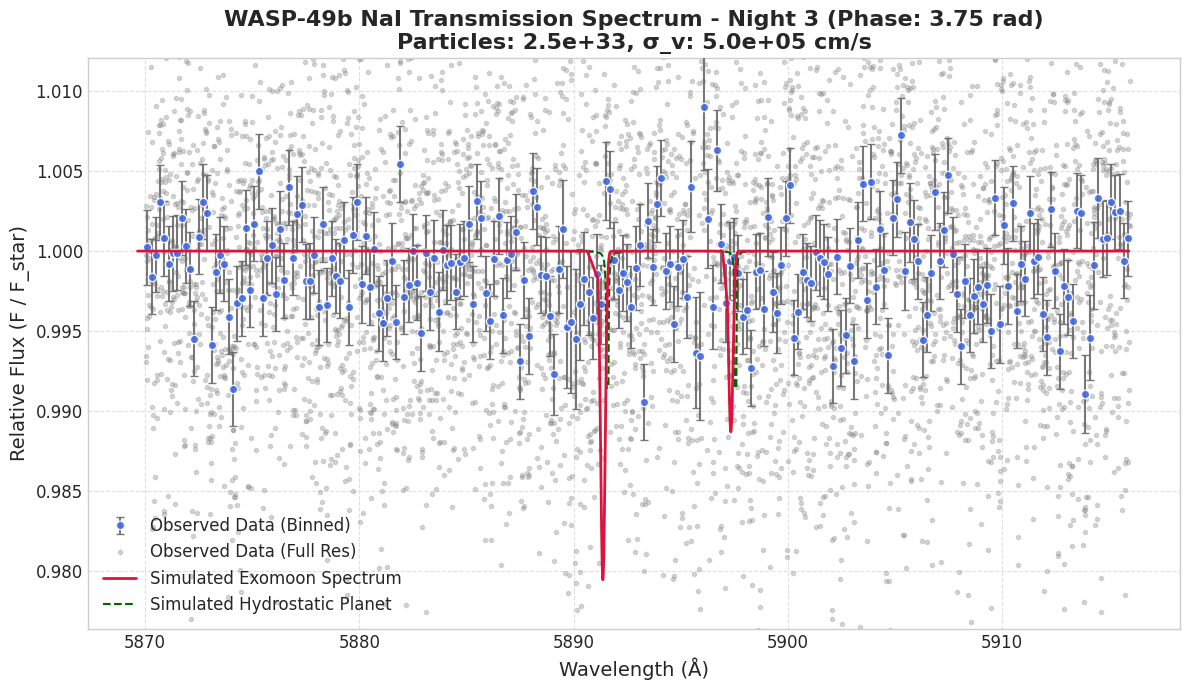

In [8]:
# SECTION 5: TRANSMISSION SPECTRA SIMULATION AND PLOTTING

if selected_solution is not None:
    run_spectra = input(
        "\nDo you want to generate a comparative transmission spectrum for each night? (yes/no): ").strip().lower()
    if run_spectra == 'yes':
        print("\n--- Preparing Transmission Spectra Simulations ---")

        # --- Get File Paths for Observed Spectrum Data ---
        print("\nEnter file paths for observed spectra. Use {} for the night number.")
        binned_spec_path = input(
            "Path to BINNED spectrum data (e.g., 'data/binned/night_{}.txt'): ").strip()
        full_spec_path = input(
            "Path to FULL-RES spectrum data (e.g., 'data/full/night_{}.txt'): ").strip()

        # --- Generate Comparative Hydrostatic Spectrum (Once) ---
        print("\n--- Generating Comparative Hydrostatic Spectrum ---")
        hydro_spec_params = get_hydrostatic_params(
            planet_name=PLANET_NAME, element_name=ELEMENT_NAME, mixing_ratio=1.7e-6,
            temperature=1500, reference_pressure_bar=1.0, mean_molecular_weight_amu=2.3,
            light_curve=False
        )

        # We'll set the wavelength range for the hydrostatic model based on the first night's data later

        hydro_model, hydro_R_values, _ = run_prometheus_simulation(
            hydro_spec_params)
        hydro_spec_raw = hydro_R_values[0, :].copy()
        hydro_spec_norm = hydro_spec_raw / np.max(hydro_spec_raw)
        hydro_wavs = hydro_model.wavelength

        # --- Loop Through Nights to Generate Exomoon Spectra ---
        for i, date_str in enumerate(observation_dates):
            night_num = i + 1
            print(
                f"\n--- Simulating and Plotting Spectrum for Night {night_num} ({date_str}) ---")

            # Load both binned and full-res observed data for this night
            obs_w_binned, obs_t_binned, obs_e_binned = load_observed(
                binned_spec_path.format(night_num))
            obs_w_full, obs_t_full, _ = load_observed(
                full_spec_path.format(night_num))

            # Get refined phase for this night from the selected solution
            phase_col_name = f'Phase of date {date_str}'
            refined_phase_fraction = selected_solution[phase_col_name]
            final_phase_rad = refined_phase_fraction * (2 * np.pi)
            print(f"Using refined phase: {final_phase_rad:.4f} radians")

            # Get parameters for the exomoon spectrum, using the binned data for wavelength range
            exomoon_spec_params = get_exomoon_params(
                PLANET_NAME, ELEMENT_NAME, NUM_PARTICLES, SIGMA_V, MOON_RADIUS_IO,
                final_phase_rad, MOON_EXOSPHERE_Q, light_curve=False,
                observed_wavelength_transmissions=obs_w_binned
            )

            exomoon_model, exomoon_R_values, _ = run_prometheus_simulation(
                exomoon_spec_params)

            # Extract and normalize the exomoon spectrum
            exomoon_spec_raw = exomoon_R_values[0, :].copy()
            exomoon_spec_norm = exomoon_spec_raw / np.max(exomoon_spec_raw)
            exomoon_wavs = exomoon_model.wavelength

            # --- Plot Everything for This Night ---
            plot_transmission_spectrum(
                wavelength_sim=exomoon_wavs,
                spectrum_sim=exomoon_spec_norm,
                element_name=ELEMENT_NAME,
                planet_name=PLANET_NAME,
                num_particles_str=f"{NUM_PARTICLES:.1e}",
                sigma_v_str=f"{SIGMA_V:.1e}",
                obs_wavelength_binned=obs_w_binned,
                obs_transmission_binned=obs_t_binned,
                obs_errors_binned=obs_e_binned,
                obs_wavelength_full=obs_w_full,
                obs_transmission_full=obs_t_full,
                wavelength_hydro=hydro_wavs,
                spectrum_hydro=hydro_spec_norm,
                title_suffix=f" - Night {night_num} (Phase: {final_phase_rad:.2f} rad)"
            )
else:
    # This message will show if the light curve section was skipped or failed
    print("\nSkipping transmission spectra generation as no valid orbital solution was selected.")

In [9]:
def get_plume_params(
    planet_name: str,
    element_name: str,
    num_particles: float,
    sigma_v: float,
    plume_radius: float,
    # The longitude of the plume source, treated as an "orbital phase"
    plume_longitude: float,
    moon_q: float,
    light_curve: bool = False,
    observed_planet_phases: Optional[np.ndarray] = None,
    observed_wavelength_transmissions: Optional[np.ndarray] = None
) -> Dict[str, Any]:
    """
    Sets up parameters for a plume scenario by adapting the exomoon model.
    """
    # First, get all the standard parameters for an exomoon scenario
    params = get_exomoon_params(
        planet_name, element_name, num_particles, sigma_v, plume_radius,
        plume_longitude, moon_q, light_curve,
        observed_planet_phases, observed_wavelength_transmissions
    )

    # Now, make the critical change for a plume:
    # Set the orbital distance of the "moon" to the planet's radius.
    planet_obj = bodies.AvailablePlanets().findPlanet(planet_name)
    params["Architecture"]["a_moon"] = planet_obj.R

    # Also, it's good practice to update the grid to be centered on the planet
    params["Grids"]["x_border"] = 5.0 * planet_obj.R

    return params

--- Setting up simulations for LHS-1140b ---

--- Generating baseline Hydrostatic Model ---
Running PROMETHEUS for Hydrostatic model...
Simulation finished. Elapsed time: 0:00:01.737533
Hydrostatic model generated successfully.

--- Simulating Plume at Longitude: 0.0 degrees (0.00 rad) ---
Running PROMETHEUS for Exomoon model...
Simulation finished. Elapsed time: 0:00:00.498264


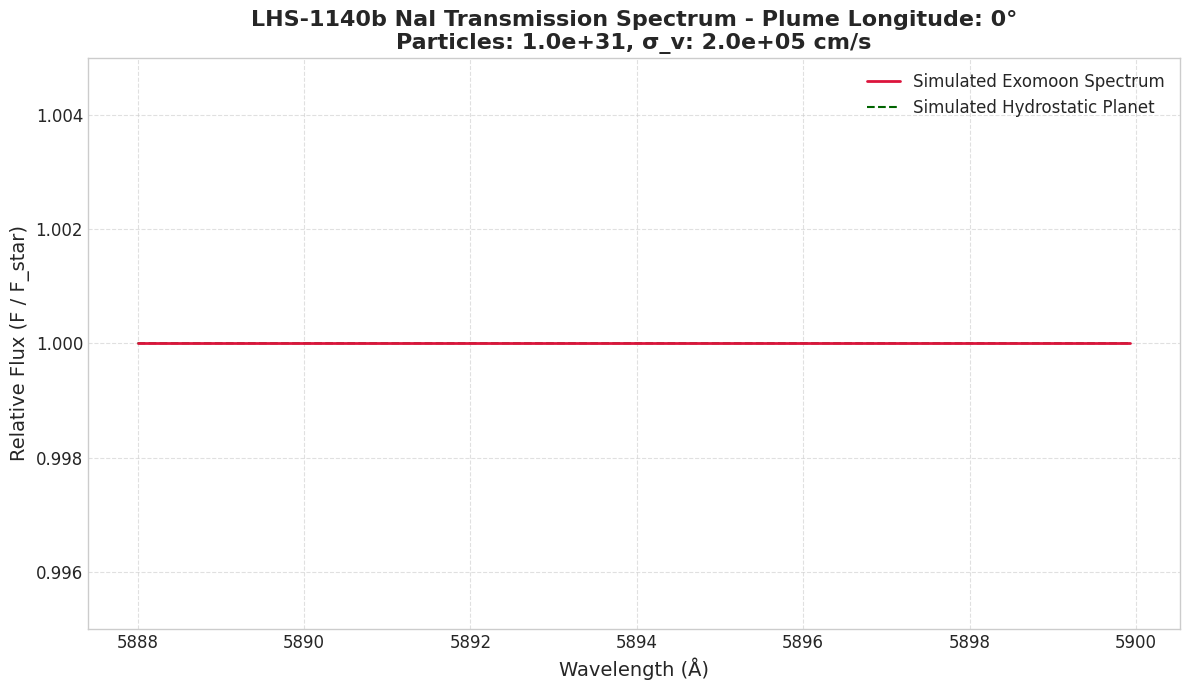


--- Simulating Plume at Longitude: 90.0 degrees (1.57 rad) ---
Running PROMETHEUS for Exomoon model...
Simulation finished. Elapsed time: 0:00:00.455786


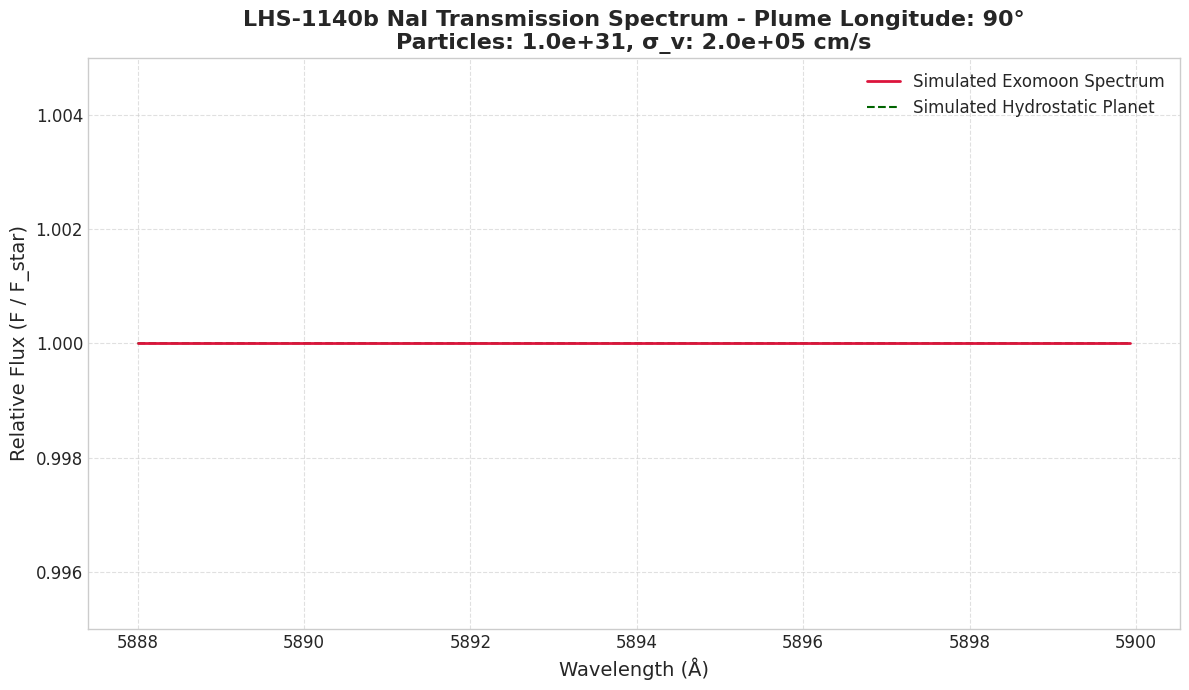


--- Simulating Plume at Longitude: 180.0 degrees (3.14 rad) ---
Running PROMETHEUS for Exomoon model...
Simulation finished. Elapsed time: 0:00:00.488024


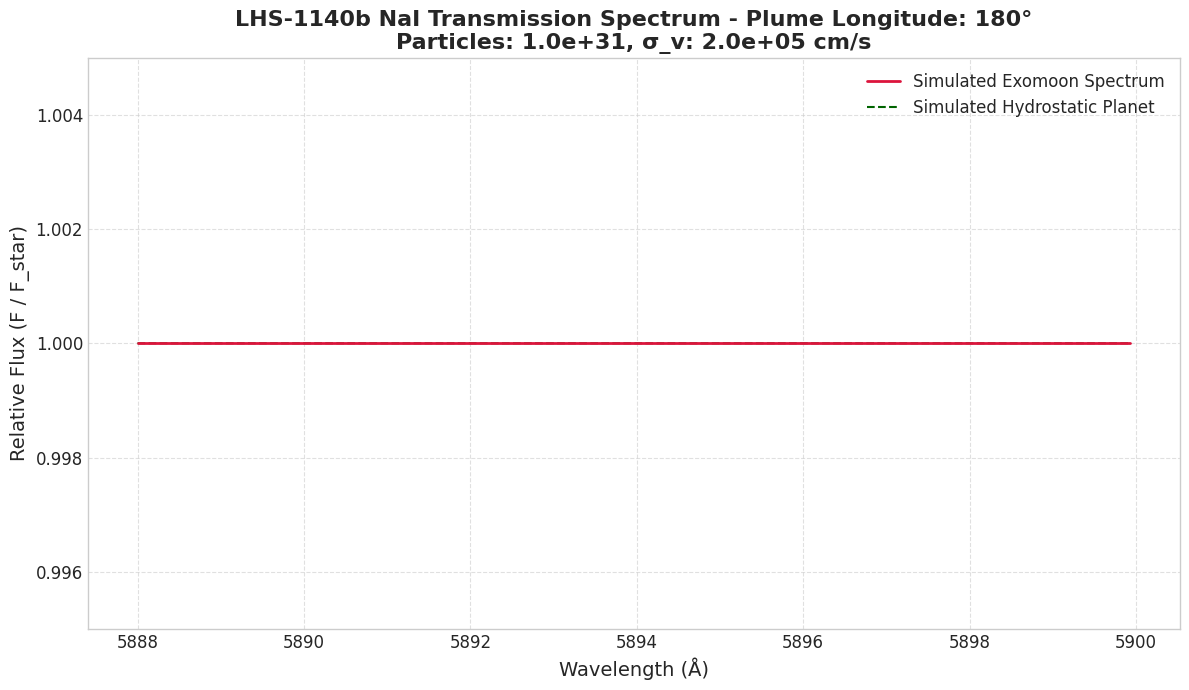


--- Simulating Plume at Longitude: 270.0 degrees (4.71 rad) ---
Running PROMETHEUS for Exomoon model...
Simulation finished. Elapsed time: 0:00:00.484470


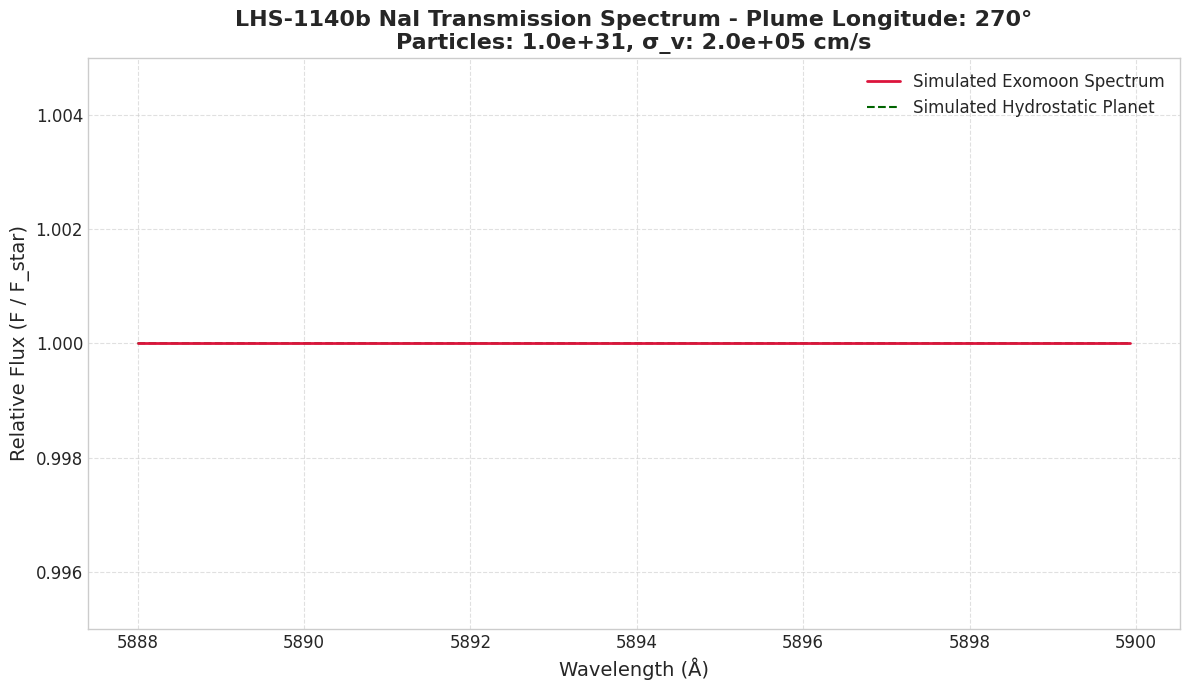

In [10]:
# SECTION: SIMULATE LHS 1140 b - HYDROSTATIC vs. PLUME SCENARIOS

# --- 1. Simulation Setup and Parameters ---
PLANET_NAME = "LHS-1140b"
ELEMENT_NAME = "NaI" # Sodium is a good tracer for this kind of analysis

# Plume parameters (analogous to an exomoon)
# These are the values you can adjust to see different effects.
NUM_PARTICLES_PLUME = 1e31  # Total number of particles sourced by the plume
SIGMA_V_PLUME = 2e5         # Velocity dispersion of particles in cm/s (thermal + non-thermal broadening)
PLUME_RADIUS = 100 * 1e5 # Plume source radius in cm (100 km, typical for a large plume)

# Hydrostatic atmosphere parameters
MIXING_RATIO_HYDRO = 1.7e-6 # Solar abundance mixing ratio for Na
TEMP_HYDRO = 300            # A plausible isothermal temperature for the atmosphere in Kelvin
REF_PRESSURE_HYDRO = 1.0    # Reference pressure in bars at the planet's surface radius
MEAN_MU_HYDRO = 2.3         # Mean molecular weight for a H2/He dominated atmosphere

# We will test several plume longitudes (0, 90, 180, 270 degrees)
# 0 (Sub-stellar point from star's view), pi (Sub-observer point), pi/2 & 3pi/2 (terminators)
plume_longitudes_rad = [0.0, np.pi/2, np.pi, 3*np.pi/2]

print(f"--- Setting up simulations for {PLANET_NAME} ---")

# --- 2. Run Hydrostatic Simulation (Baseline) ---
# This only needs to be run once as it's the same for all comparisons.
print("\n--- Generating baseline Hydrostatic Model ---")
hydro_params = get_hydrostatic_params(
    planet_name=PLANET_NAME,
    element_name=ELEMENT_NAME,
    mixing_ratio=MIXING_RATIO_HYDRO,
    temperature=TEMP_HYDRO,
    reference_pressure_bar=REF_PRESSURE_HYDRO,
    mean_molecular_weight_amu=MEAN_MU_HYDRO,
    light_curve=False # We want a spectrum
)

hydro_model, hydro_R_values, _ = run_prometheus_simulation(hydro_params)

# Extract and normalize the hydrostatic spectrum
if hydro_R_values.ndim == 2 and hydro_R_values.shape[0] > 0:
    hydro_spec_raw = hydro_R_values[0, :].copy()
    hydro_spec_norm = hydro_spec_raw / np.max(hydro_spec_raw)
    hydro_wavs = hydro_model.wavelength
    print("Hydrostatic model generated successfully.")
else:
    print("ERROR: Hydrostatic simulation failed to produce a valid spectrum.")
    hydro_wavs, hydro_spec_norm = None, None


# --- 3. Loop Through Plume Longitudes and Plot ---
if hydro_wavs is not None:
    for longitude in plume_longitudes_rad:
        longitude_deg = np.rad2deg(longitude)
        print(f"\n--- Simulating Plume at Longitude: {longitude_deg:.1f} degrees ({longitude:.2f} rad) ---")

        # Get parameters for the plume scenario.
        # This uses the 'get_plume_params' helper which treats the plume
        # as an exomoon at the planet's surface.
        plume_params = get_plume_params(
            planet_name=PLANET_NAME,
            element_name=ELEMENT_NAME,
            num_particles=NUM_PARTICLES_PLUME,
            sigma_v=SIGMA_V_PLUME,
            plume_radius=PLUME_RADIUS,
            plume_longitude=longitude,
            moon_q=3.34,
            light_curve=False
        )
        
        plume_model, plume_R_values, _ = run_prometheus_simulation(plume_params)
        
        # Extract, normalize, and plot the plume spectrum against the hydrostatic one
        if plume_R_values.ndim == 2 and plume_R_values.shape[0] > 0:
            plume_spec_raw = plume_R_values[0, :].copy()
            plume_spec_norm = plume_spec_raw / np.max(plume_spec_raw)
            plume_wavs = plume_model.wavelength

            # Plot the comparison
            plot_transmission_spectrum(
                wavelength_sim=plume_wavs,
                spectrum_sim=plume_spec_norm,
                element_name=ELEMENT_NAME,
                planet_name=PLANET_NAME,
                num_particles_str=f"{NUM_PARTICLES_PLUME:.1e}",
                sigma_v_str=f"{SIGMA_V_PLUME:.1e}",
                # No observed data to plot
                obs_wavelength_binned=None,
                obs_transmission_binned=None,
                obs_errors_binned=None,
                # Pass the pre-calculated hydrostatic model
                wavelength_hydro=hydro_wavs,
                spectrum_hydro=hydro_spec_norm,
                title_suffix=f" - Plume Longitude: {longitude_deg:.0f}°"
            )
        else:
            print(f"ERROR: Plume simulation failed for longitude {longitude_deg:.1f}°.")

--- Setting up light curve simulations for LHS-1140b ---

--- Generating baseline Hydrostatic Light Curve Model ---
Running PROMETHEUS for Hydrostatic model...
Simulation finished. Elapsed time: 0:05:55.958360
Hydrostatic light curve model generated successfully.

--- Simulating Plume Light Curve at Longitude: 0.0 degrees ---
Running PROMETHEUS for Exomoon model...
Simulation finished. Elapsed time: 0:01:54.156736


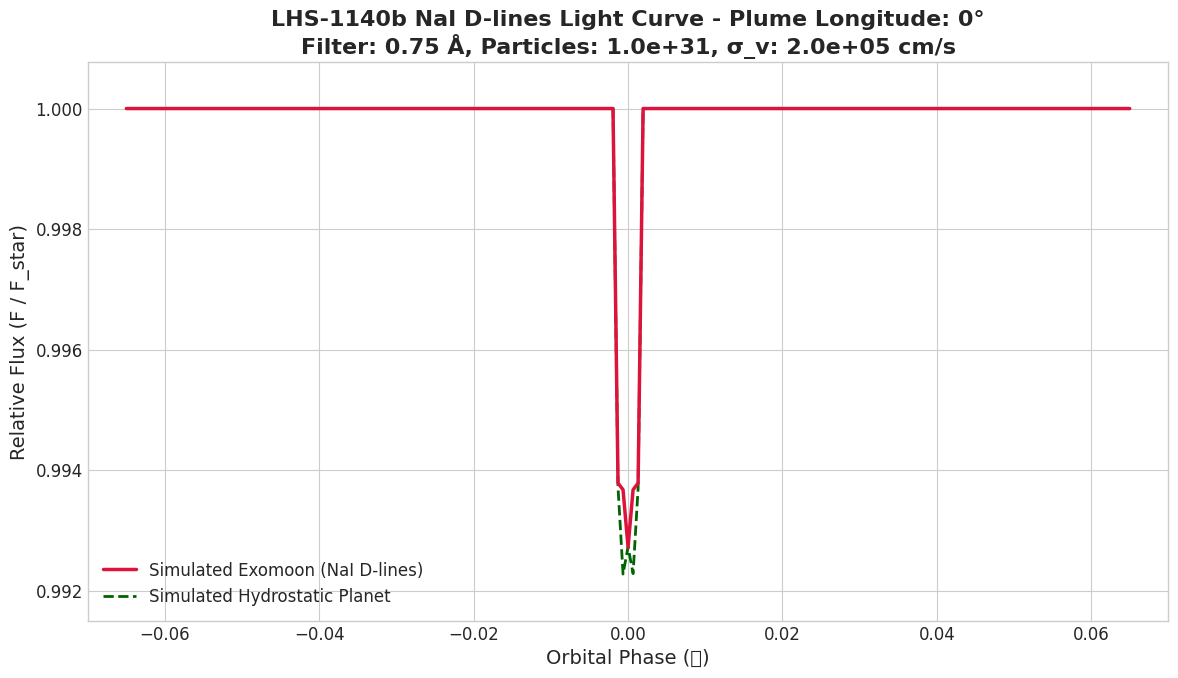


--- Simulating Plume Light Curve at Longitude: 90.0 degrees ---
Running PROMETHEUS for Exomoon model...
Simulation finished. Elapsed time: 0:01:44.160880


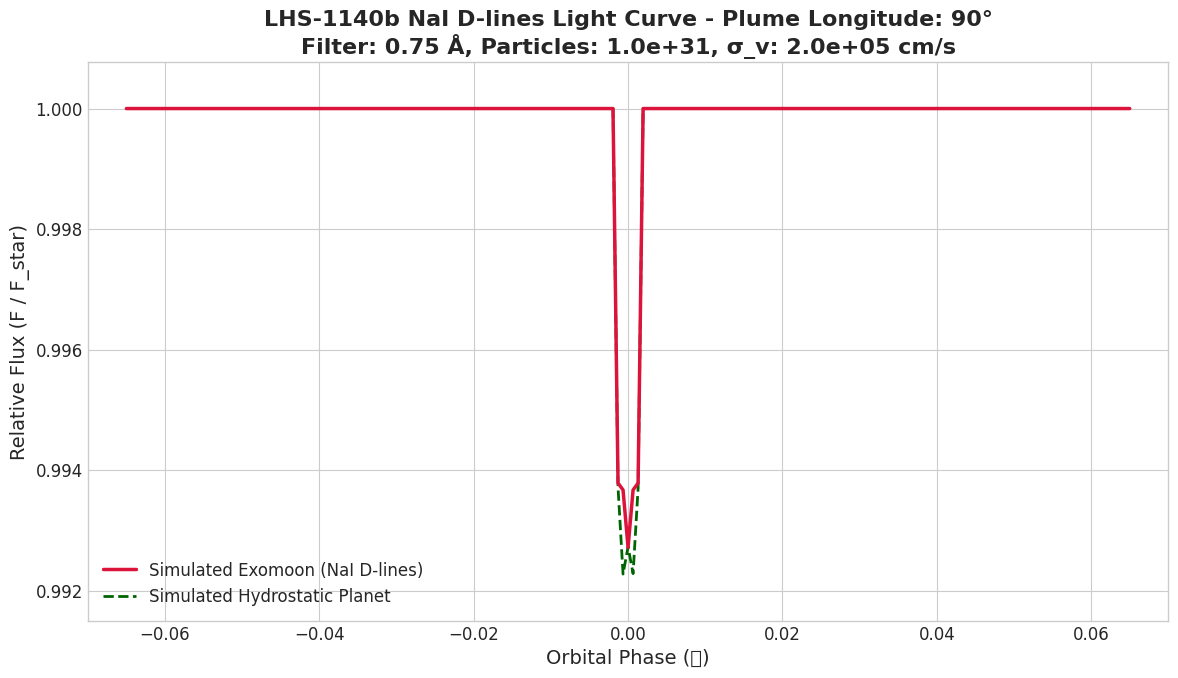


--- Simulating Plume Light Curve at Longitude: 180.0 degrees ---
Running PROMETHEUS for Exomoon model...
Simulation finished. Elapsed time: 0:01:49.545363


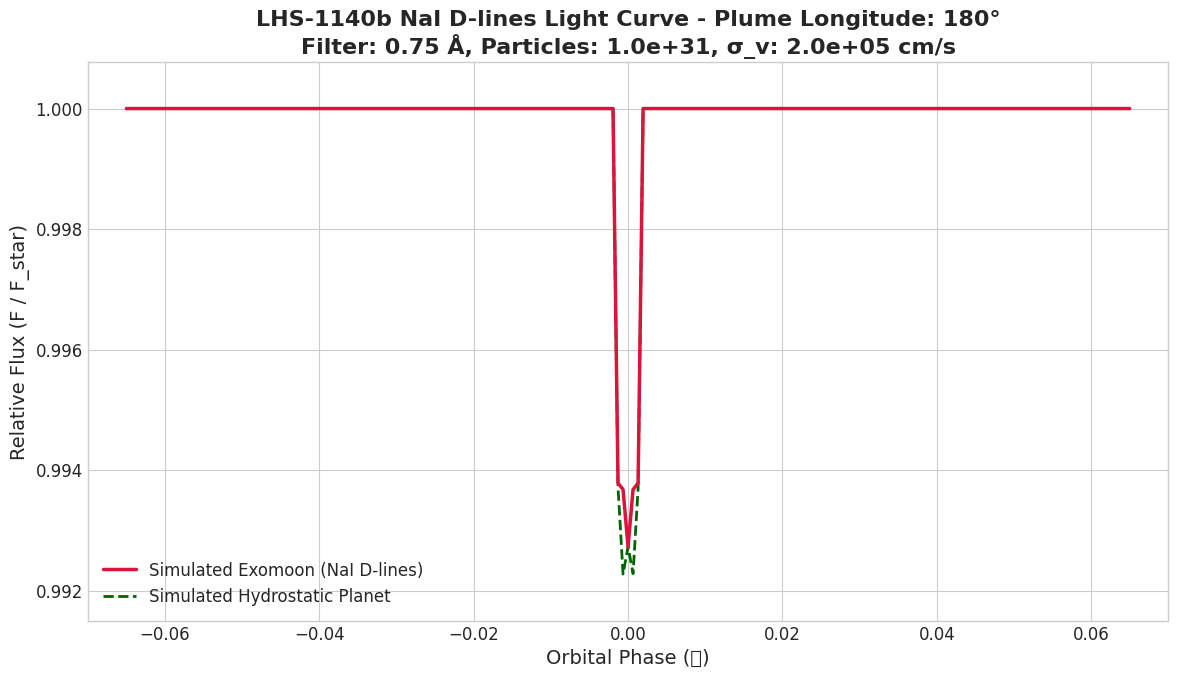


--- Simulating Plume Light Curve at Longitude: 270.0 degrees ---
Running PROMETHEUS for Exomoon model...
Simulation finished. Elapsed time: 0:01:44.114649


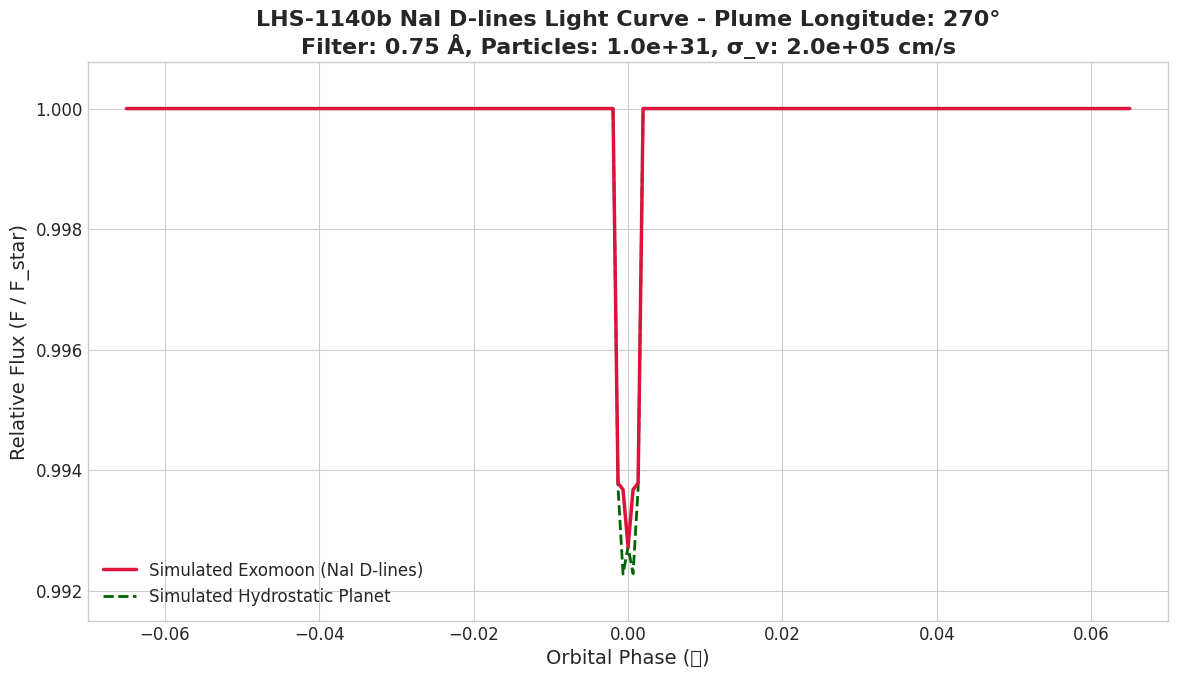

In [11]:
# SECTION: SIMULATE LHS 1140 b LIGHT CURVES - HYDROSTATIC vs. PLUME SCENARIOS

FILTER_BANDWIDTH_ANGSTROM = 0.75
FILTER_BANDWIDTH_CM = FILTER_BANDWIDTH_ANGSTROM * 1e-8

print(f"--- Setting up light curve simulations for {PLANET_NAME} ---")

# --- 2. Run Hydrostatic Light Curve Simulation (Baseline) ---
# This is run once and used as the comparison for all plume plots.
print("\n--- Generating baseline Hydrostatic Light Curve Model ---")
hydro_params_lc = get_hydrostatic_params(
    planet_name=PLANET_NAME,
    element_name=ELEMENT_NAME,
    mixing_ratio=MIXING_RATIO_HYDRO,
    temperature=TEMP_HYDRO,
    reference_pressure_bar=REF_PRESSURE_HYDRO,
    mean_molecular_weight_amu=MEAN_MU_HYDRO,
    light_curve=True
)

hydro_model, hydro_R_values, _ = run_prometheus_simulation(hydro_params_lc)

# Process the resulting spectra into a light curve
if hydro_R_values.ndim == 2 and hydro_R_values.shape[0] > 0:
    phases_hydro, lc_hydro = calculate_light_curve_from_spectra(
        hydro_model, hydro_R_values, hydro_model.spatialGrid, FILTER_BANDWIDTH_CM
    )
    print("Hydrostatic light curve model generated successfully.")
else:
    print("ERROR: Hydrostatic simulation failed to produce a valid light curve.")
    phases_hydro, lc_hydro = None, None

# --- 3. Loop Through Plume Longitudes and Plot Light Curves ---
if phases_hydro is not None:
    for longitude in plume_longitudes_rad:
        longitude_deg = np.rad2deg(longitude)
        print(f"\n--- Simulating Plume Light Curve at Longitude: {longitude_deg:.1f} degrees ---")

        # Get parameters for the plume scenario with light_curve=True
        plume_params_lc = get_plume_params(
            planet_name=PLANET_NAME,
            element_name=ELEMENT_NAME,
            num_particles=NUM_PARTICLES_PLUME,
            sigma_v=SIGMA_V_PLUME,
            plume_radius=PLUME_RADIUS,
            plume_longitude=longitude,
            moon_q=3.34,
            light_curve=True # Set to True for light curve
        )
        
        plume_model, plume_R_values, plume_scenarios = run_prometheus_simulation(plume_params_lc)
        
        # Process the plume spectra into a light curve
        if plume_R_values.ndim == 2 and plume_R_values.shape[0] > 0:
            # Calculate the line-of-sight velocity of the plume source as the planet transits
            v_los = np.array([plume_scenarios[0].moon.getLOSvelocity(ph) for ph in plume_model.spatialGrid.constructOrbphaseAxis()])
            
            phases_plume, lc_plume = calculate_light_curve_from_spectra(
                plume_model, plume_R_values, plume_model.spatialGrid, FILTER_BANDWIDTH_CM, v_los_planet=v_los
            )

            # Plot the comparison light curve
            plot_light_curve(
                orbital_phases_sim=phases_plume,
                light_curve_values_sim=lc_plume,
                # No observed data to plot
                orbital_phases_obs=None,
                light_curve_values_obs=None,
                light_curve_errors_obs=None,
                element_name=f"{ELEMENT_NAME} D-lines",
                planet_name=PLANET_NAME,
                num_particles_str=f"{NUM_PARTICLES_PLUME:.1e}",
                sigma_v_str=f"{SIGMA_V_PLUME:.1e}",
                filter_bandwidth_angstrom=FILTER_BANDWIDTH_ANGSTROM,
                # Pass the pre-calculated hydrostatic model for comparison
                orbital_phases_hydro=phases_hydro,
                light_curve_values_hydro=lc_hydro,
                title_suffix=f" - Plume Longitude: {longitude_deg:.0f}°"
            )
        else:
            print(f"ERROR: Plume light curve simulation failed for longitude {longitude_deg:.1f}°.")